In [37]:
# !pip install -U langgraph langsmith
# !pip install dotenv
# !pip install langchain_ollama langchain_nomic langchain_mistralai psycopg2

In [57]:
from dotenv import load_dotenv
load_dotenv()
import json
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage
# Required libraries
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from typing import Dict

import os

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
print(MISTRAL_API_KEY)

a5hswwU9FlKoR7z1p0dBqAgQBiSaj5hp


In [58]:
from langchain_ollama import OllamaEmbeddings
from langchain_nomic import NomicEmbeddings
from langchain_mistralai import ChatMistralAI

# For the embedding we, are going to use OllamaEmbeddings with the nomic-embed-text model
# This model is a 7B model that is trained to embed text
embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)
llm = ChatMistralAI(model="mistral-large-latest", temperature=0, api_key=MISTRAL_API_KEY)

In [69]:
from prompts.formatPrompt import prompt_generator as formatPrompt
from prompts.improvePrompt import prompt_generator as improvePrompt
from prompts.rolePrompt import prompt_generator as rolePrompt
from prompts.matchPrompt import prompt_generator as matchPrompt 
from prompts.summaryPrompt import prompt_generator as summaryPrompt

from typing import Annotated, Optional, TypedDict
from langgraph.channels import LastValue
from tenacity import retry,wait_exponential, stop_after_attempt
class ResumeState(TypedDict, total=False):
    resume: Annotated[str, LastValue]
    jd: Annotated[Optional[str], LastValue]
    format_result: Optional[str]
    match_result: Optional[str]
    improved: Optional[str]
    role_suggestions: Optional[str]
    summary: Optional[str]




@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(5))
def format_node(state: ResumeState) -> ResumeState:
    prompt = formatPrompt(state["resume"])
    result = llm.invoke([prompt])
    return {**state, "format_result": result.content}


@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(5))
def match_node(state: ResumeState) -> ResumeState:
    prompt = matchPrompt(state["resume"], state.get("jd"))
    result = llm.invoke([prompt])
    return {**state, "match_result": result.content}


@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(5))
def improve_node(state: ResumeState) -> ResumeState:
    prompt = improvePrompt(state["resume"])
    result = llm.invoke([prompt])
    return {**state, "improved": result.content}


@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(5))
def role_node(state: ResumeState) -> ResumeState:
    prompt = rolePrompt(state["resume"])
    result = llm.invoke([prompt])
    return {**state, "role_suggestions": result.content}


def summarizer_node(state: ResumeState) -> Dict[str, Any]:
    print("summarizer_node : state", state)
    prompt = summaryPrompt(state.get('format_result'), state.get('match_result'), state.get('improved'), state.get('role_suggestions'))
    result = llm.invoke([prompt])
    return {**state, "summary": result.content}



In [70]:

graph = StateGraph(state_schema=ResumeState)

graph.add_node("format_eval", RunnableLambda(format_node))
graph.add_node("match_eval", RunnableLambda(match_node))
graph.add_node("improve_eval", RunnableLambda(improve_node))
graph.add_node("role_suggest", RunnableLambda(role_node))
graph.add_node("summarize", RunnableLambda(summarizer_node))

# Dispatcher
graph.add_node("broadcast", RunnableLambda(lambda s: s))

graph.set_entry_point("broadcast")

graph.add_edge("broadcast", "format_eval")
graph.add_edge("broadcast", "match_eval")
graph.add_edge("broadcast", "improve_eval")
graph.add_edge("broadcast", "role_suggest")

# Final summary aggregation
graph.add_edge("format_eval", "summarize")
graph.add_edge("match_eval", "summarize")
graph.add_edge("improve_eval", "summarize")
graph.add_edge("role_suggest", "summarize")
graph.add_edge("summarize", END)

app = graph.compile()

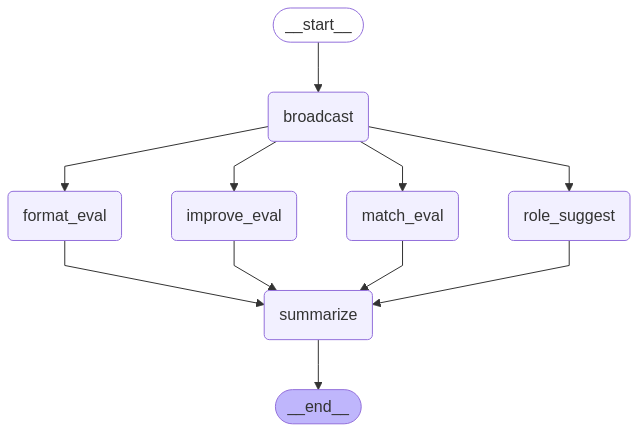

In [71]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
output = app.invoke([{
    "resume": "Backend engineer with Java, Spring Boot, and AWS.",
    "jd": "Looking for DevOps engineer with experience in AWS, Docker, and CI/CD."
}])

print(output["Final Report"])


In [ ]:
# Install missing libraries
%pip install transformers peft torch


In [ ]:

from transformers import AutoModel, AutoTokenizer
from peft import PeftModel
import torch
import torch.nn.functional as F

# Load models
base_model = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5")
model = PeftModel.from_pretrained(base_model, "shashu2325/resume-job-matcher-lora")
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-large-en-v1.5")

# Example texts
resume_text = """ Mitansh Jigneshkumar Gor
San Jose, California | +16692687286 | gormitansh18@gmail.com
GitHub | leetCode | Linkedin | Portfolio | Blogs | HackerRank
EDUCATION
●
●
Master of Science in Engineering | San Jose State University, San Jose, California | Bachelor of Technology in Computer Engineering | Indus University, India | 9.4/10.0 SKILLS AND TECH STACK
2024 - 2026
2019 - 2023
Language: Javascript, Java, Python.
Backend: Nodejs, Springboot, Typescript, Terraform, Serverless, CI/CD, CloudFormation, RestAPI, OpenAPI, swagger
Database: MySql, RDS, MongoDB, PostgreSQL, DynamoDB, S3, AWS Glue, AWS Elastic Cache, firebase.
Cloud: AWS, Serverless Architecture, Event-Driven Architecture, ElastiCache, Kinesis, SNS, SQS, Lambda Function, Step Function.
Others: React.js, AngularJS, Vue.js, Docker, Git, GitHub, GitLab, Agile, SDLC, Jira, Confluence.GitHub Actions, Middy, Husky, Drawio.
WORK EXPERIENCE
Distinction.Dev Remote
Software Engineer, Cloud Engineer 10/2022 - 02/2024
●
Engineered decoupled, idempotent ETL processes using AWS Step Functions, SQS, and Kinesis, achieving a 30% reduction in data
discrepancies and significantly boosting system reliability within the first quarter.
●
Architected a highly scalable file upload system using AWS Multi-Part Upload, increasing file size capacity from 5 GB to 5 TB and
enabling seamless management of large files, significantly boosting platform flexibility.
●
Built and implemented a robust CI/CD pipeline using AWS CloudFormation and Serverless, enabling 25 successful releases with zero
critical bugs in the initial month by automating testing and code reviews.
●
Spearheaded LexiCon, a cross-functional project to develop an internal newsletter platform improving communication efficiency by 40%
Neerx Technovation Pvt Ltd Remote
SDE Intern, Cloud Developer 09/2021 - 10/2022
●
Achieved a 40% scalability improvement by optimizing backend microservices using Java Spring Boot, AWS, and NoSQL, implementing
modular coding practices within an agile environment.
●
Designed and built an open API service for an external REST API portal, improving performance and scalability by 50% with asynchronous
processing and queue-based architecture.
●
Resolved top system crash sources and improved stability by leading a data-cleaning initiative with Python scripting, organizing over 10 TB
of technical data in three months.
PROJECT EXPERIENCE
Security Surveillance Robot Simulation System Development (AWS, Carla Simulator, React, Node.js, Flask, Linux)
●
Created a real-time robotic simulation platform using Carla Simulator, streaming critical telemetry data and video to interactive dashboards
every second; streamlined operations saved approximately 30 hours of manual work per week dedicated to vehicle testing and management.
Attendance Tracking and Billing System (Spring Framework, Postgres, and Angular)
●
Boosted operational efficiency by 100% by developing and deploying a startup's automated attendance and billing system, leveraging
Spring, Postgres, Angular, and Chart.js for data visualization.
Counseling and Seminar Automation System (Spring Framework, Postgres, and Android)
●
Enhanced seminar accessibility and scheduling efficiency by developing a web and Android counseling system with AWS SQS and AWS
SNS features, reaching 50+ Play Store downloads within the initial launch period.
CERTIFICATION & ACHIEVEMENTS
●
Secured the 2nd position in an internal college hackathon organized by Indus University.
●
Python, Java, JavaScript 5-star Certification @ hackerrank.
●
CERTIFICATES: AWS cloud Practitioner, Neural Networks and Deep Learning, Java, Python, Angular, Responsive Web Design, Spring
Boot, Mean Stack, Cryptography, and Hashing Fundamentals in Python and Java.
VOLUNTEERING EXPERIENCE
Campus Ambassador at CVDragon, IIT Bombay, IIT Kanpur 11/2020 - 04/2021
●
Increased platform sign-ups by 20% through targeted campaigns as a Campus Ambassador for CVDragon at IIT Bombay and IIT Kanpur,
recruiting 10 ambassadors and enhancing engagement through targeted marketing campaigns.
Mentor & Event Planner at Royal Technosoft Pvt Ltd 06/2020 - 10/2020
●
Trained 500+ international students in programming and algorithms through six boot camps and five seminars, leveraging strong
communication to guide career advancement solutions."""
job_text = """


You’ll collaborate with a cross-functional team of engineers, product managers, data scientists, and designers to build and improve the software systems that help utilities manage EV charging and modernize the electric grid.

Core Responsibilities

* Design and build scalable backend services, APIs, and data pipelines to support internal tools and utility-facing applications.
* Contribute to full-stack development, including intuitive, performant UIs using modern frameworks like React.
* Support development of machine learning infrastructure and data platforms that drive intelligent decision-making for utility partners.
* Participate in sprint planning, code reviews, and team standups to ensure high-quality, collaborative software development.
* Conduct research and experimentation on new tools, frameworks, or models to improve product performance and reliability.
* Contribute to special projects and other duties as designated by your mentor or assigned designee. 
About you

* Currently pursuing a Bachelor’s or Master’s degree in Computer Science, Engineering, Data Science, or a related field.
* Expected graduation of December 2025 or later.
* Demonstrated software engineering experience from internships, school projects, or personal work. Comfortable coding in languages such as Python, Go, JavaScript/TypeScript, or Java.
* Exposure to front-end development (HTML, CSS, JavaScript) and frameworks like React or Vue.js is a plus. Familiarity with cloud infrastructure (e.g., AWS, GCP), databases (e.g., PostgreSQL), or data tools (e.g., Apache Beam, Airflow) is beneficial. Strong interest in clean energy, climate tech, and building software with real-world impact.
* Eager to learn, grow, and contribute in a fast-paced, mission-driven environment.
* Location for this role is SF Bay Area preferred.  
Salary

The expected compensation for this opportunity is between $25-40 an hour."""

# Process texts
resume_inputs = tokenizer(resume_text, return_tensors="pt", max_length=512, padding="max_length", truncation=True)
job_inputs = tokenizer(job_text, return_tensors="pt", max_length=512, padding="max_length", truncation=True)

# Get embeddings
with torch.no_grad():
    # Get embeddings using mean pooling
    resume_outputs = model(**resume_inputs)
    job_outputs = model(**job_inputs)
    
    # Mean pooling
    resume_emb = resume_outputs.last_hidden_state.mean(dim=1)
    job_emb = job_outputs.last_hidden_state.mean(dim=1)
    
    # Normalize and calculate similarity
    resume_emb = F.normalize(resume_emb, p=2, dim=1)
    job_emb = F.normalize(job_emb, p=2, dim=1)
    
    similarity = torch.sum(resume_emb * job_emb, dim=1)
    match_score = torch.sigmoid(similarity).item()

print(f"Match score: {match_score:.4f}")


Match score: 0.6293
